In [1]:
#Estabelecendo o environment na máquina que usei

import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
#Imports

import emcee
import corner
import nflows

from astropy.io import fits
from astropy.table import Table

import pandas as pd
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import time
import torch.utils.data
from torch.nn import functional as F
from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
print('Pytorch:',torch.__version__)
if torch.cuda.is_available() is True:
    print(torch.cuda.get_device_name(0))

# Fixe as seeds para manter o código reprodutível
torch.manual_seed(1)
np.random.seed(1)

Device: cuda
Pytorch: 1.10.1+cu102
GeForce RTX 2080 Ti


In [3]:
# Usaremos esse dicionário para passar os parâmetros
class dotdict(dict): 
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

In [4]:
# Parâmetros para o processo de treinamento
args = dotdict()
args.learning_rate = 1e-4 
args.num_epochs = 8
args.log_interval = 2
args.batch_size = 100

In [5]:
# Esse é o catálogo onde estão os valores dos parâmetros para serem estimados
catalog_path = '/home/dados229/Data/normalizing-flows/LensPop/lenses_DESc.txt'
with open(catalog_path, 'r') as f:
    catalog = f.read()

In [6]:
cabecalho = catalog[:1430]
catalog = catalog[1430:]

In [7]:
catalog_split = catalog.split('\n')
catalog_split = catalog_split[:-1]

new_catalog_split = []
for data in catalog_split:
    line = data.split(' ')
    for i, value in enumerate(line):
        line[i] = float(value)
    new_catalog_split.append(np.array(line))
        
catalog_dict = {int(data[0]): data[1:5] for data in new_catalog_split}

In [8]:
#Esses são os parâmetros em que estamos interessados, então vamos fazer o datafram apenas com eles

columns = ['zl', #redshift da lente
           'zs', #redshift da fonte
           'b', #Raio de Einstein (arcseconds)
           'sig_v' #Dispersão de velocidades da lente (km/s)
          ]

In [9]:
catalog_df = pd.DataFrame.from_dict(catalog_dict, orient='index', columns=columns)
catalog_df.head()

,zl,zs,b,sig_v
0,0.320,1.784,1.497,265.112
1,0.402,1.790,1.372,264.665
3,0.569,1.285,1.361,318.578
4,0.189,3.385,1.686,257.082
5,0.568,1.057,0.658,242.661


In [10]:
data_path='/home/dados229/Data/normalizing-flows/LensPop/images/'

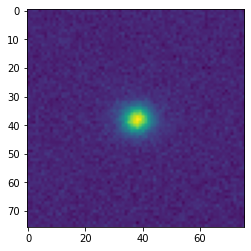

In [11]:
#Aqui vamos dar uma olhada nas imagens do nosso dataset

with fits.open(data_path+"100/image_i_SDSS.fits", ignore_missing_end=True) as hdul:
    data = hdul[0].data
    
plt.imshow(data)

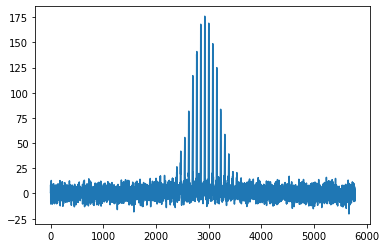

In [12]:
#E ver com elas ficam flatenizadas, pois nossa IA só aceita entradas 1D

flat_data = data.reshape(-1)
flat_data.shape

plt.plot(flat_data)

Agora vamos carregar todo o dataset já flatenizando as imagens.

Vamos montar uma versão com 3 bandas e outra com 1 única banda, a que possui os maiores picos

In [13]:
from tqdm import tqdm

images_flatten = []
unichannel_images_flatten = []

for i in tqdm(catalog_df.index):
    images_object = []
    for j in ['i','g','r']:
        with fits.open(data_path+f"{i}/image_{j}_SDSS.fits", ignore_missing_end=True) as hdul:
            data = hdul[0].data
            data_flat = data.reshape(-1)
            images_object = np.concatenate((images_object, data_flat), axis=0)
            
            if j=='i':
                unichannel_images_flatten.append(images_object)
            
            hdul.close()
    
    images_flatten.append(images_object)

images = np.array(images_flatten)

unichannel_images = np.array(unichannel_images_flatten)

catalog_df['flat_images'] = images_flatten

catalog_df['unichannel_flat_images'] = unichannel_images_flatten

catalog_df.head()

100%|██████████| 18598/18598 [01:13<00:00, 253.59it/s]


,zl,zs,b,sig_v,flat_images,unichannel_flat_images
0,0.320,1.784,1.497,265.112,"[8.79194504297805, -0.7040006191672441, 0.2971...","[8.79194504297805, -0.7040006191672441, 0.2971..."
1,0.402,1.790,1.372,264.665,"[-0.930211399899302, -8.186793312818246, 9.234...","[-0.930211399899302, -8.186793312818246, 9.234..."
3,0.569,1.285,1.361,318.578,"[3.902649039732538, 3.3019085520225095, 1.1573...","[3.902649039732538, 3.3019085520225095, 1.1573..."
4,0.189,3.385,1.686,257.082,"[2.3337825475618157, 10.718569591247585, -1.53...","[2.3337825475618157, 10.718569591247585, -1.53..."
5,0.568,1.057,0.658,242.661,"[9.17305214376101, 2.2593086455131313, 2.44397...","[9.17305214376101, 2.2593086455131313, 2.44397..."


In [14]:
values = np.array(catalog_df[['zl', 'zs', 'b', 'sig_v']])

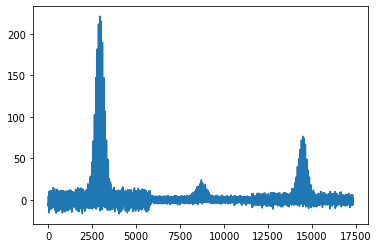

In [15]:
#Essa é a cara dos nossos dados com 3 canais flatenizados

plt.plot(images_object)

# Treinamento com 3 bandas

In [16]:
#Dividiremos o dataset em treino (75%) e teste (25%). Assim, poderemos avaliar os resultados fora dos dados de treinamento

x_train, x_test, y_train, y_test = train_test_split(images, values, test_size=0.25, random_state=50)

In [17]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, images, values):
        'Initialization'
        self.images = images
        self.values = values

  def __len__(self):
        'Denotes the total number of samples'
        return self.values.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        x = values[index,:]
        y = images[index,:]
        return x, y

training_set = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=args.batch_size,shuffle=True)

test_set = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=args.batch_size,shuffle=True)

In [18]:
#Os dados de treino são normalizados durante o treino para a rede convergir mais rapidamente
x_std = train_loader.dataset.images.std((0,1))
y_std = train_loader.dataset.values.std((0))
print('x_std, y_std: ',x_std,y_std)

x_std, y_std:  270.47831586555276 [ 0.24809922  0.75670841  0.4285546  39.70018173]


In [19]:
#Aqui estamos criando a rede utilizada

def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])


num_layers = 10 # quantidade de blocos com transformações lineares e aplicação de uma ResNet.
mhidden_features = 1200 # número de neurônios em cada camada da ResNet
base_dist = nflows.distributions.StandardNormal((4,)) # Essa é a distribuição inicial, uma Gaussiana 4D, pois possuimos 4 parâmetros 


transformsi = []
for _ in range(num_layers):
    transformsi.append(create_linear_transform(param_dim=4))
    transformsi.append(PiecewiseRationalQuadraticCouplingTransform(_, 4, mhidden_features, context_size=17328)) 
transformsi.append(create_linear_transform(param_dim=4))
transformflow = CompositeTransform(transformsi)


model = Flow(transformflow, base_dist)

In [20]:
args.y_size = 4 # Número de parâmetros
args.x_size = train_loader.dataset.images[0].shape[0] # tamanho do input
pytorch_total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params to optimize:', pytorch_total_params_grad)

Total params to optimize: 445296680


In [21]:
images = images.astype(np.double)
values = values.astype(np.double)
model = model.double()

In [22]:
#Aqui temos o treinamento da rede

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss_avg = []
time0 = time.time()

model.train()
for epoch in tqdm(range(1, args.num_epochs + 1)):
    train_loss = []
    for batch_idx, (params, data) in enumerate(train_loader):
        data = data.to(device)
        params = params.to(device)
        optimizer.zero_grad()

        x = torch.tensor(data[:,:].cpu().numpy(), dtype=torch.float32)/x_std
        y = torch.tensor(params[:,:].cpu().numpy(), dtype=torch.float32)/y_std

        optimizer.zero_grad()
        loss = -model.log_prob(inputs=y.double(), context=x.double()).mean()

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss_avg.append(np.mean(np.array(train_loss)))
    if epoch % args.log_interval ==0: print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item()))

print('Training: {0:2.2f} min'.format( (time.time()-time0)/60.) )

 25%|██▌       | 2/8 [50:24<2:31:21, 1513.63s/it]

====> Epoch: 2 Average loss: 11.3004


 50%|█████     | 4/8 [1:41:03<1:41:12, 1518.12s/it]

====> Epoch: 4 Average loss: 3.2520


 75%|███████▌  | 6/8 [2:31:52<50:43, 1521.74s/it]  

====> Epoch: 6 Average loss: 1.4511


100%|██████████| 8/8 [3:22:27<00:00, 1518.43s/it]

====> Epoch: 8 Average loss: 4.1669
Training: 202.46 min


Text(0, 0.5, '-log prob')

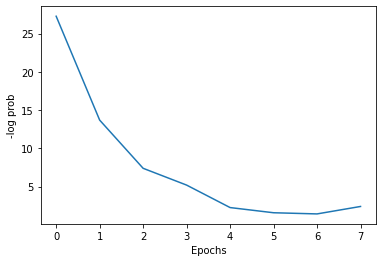

In [23]:
#Vamos plotar a evolução da loss do treinamento

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('-log prob')

## Avaliação de um exemplo

In [24]:
test_index = 50

with fits.open(data_path+f"{test_index}/image_i_SDSS.fits", ignore_missing_end=True) as hdul:
    data = hdul[0].data
    data_flat = data.reshape(-1)
    hdul.close()
    
image = data_flat.astype(dtype=np.double)

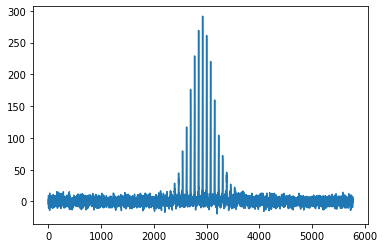

In [25]:
plt.plot(image)

[2.15000e-01 4.91000e-01 1.49300e+00 3.12472e+02]


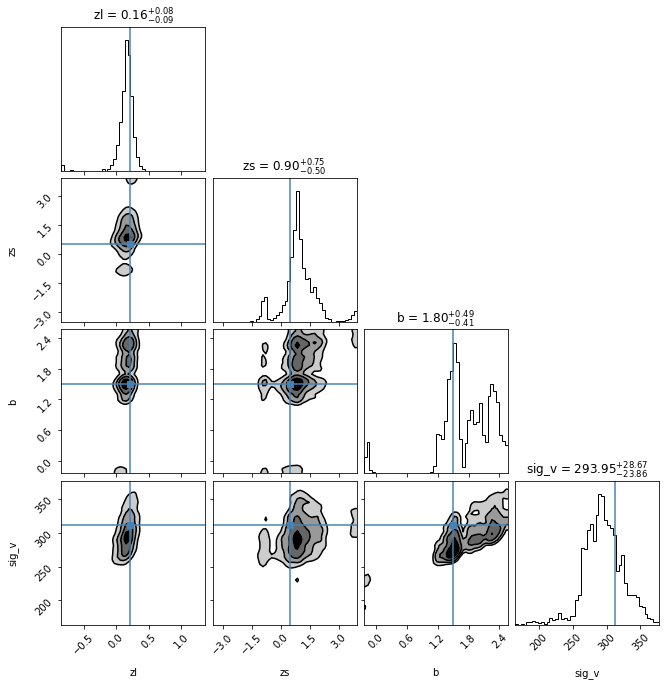

In [26]:
nsamples = 2000

zl_samples = []
zs_samples = []
b_samples =[]
sig_v_samples = []

samples_histo = model.sample(1,context=torch.tensor(x_test[test_index]).repeat(nsamples,1)/x_std).data.cpu().numpy()

samples_histo = samples_histo[:,0,:]*y_std

print(y_test[test_index]) # esse são os valores reais dos parâmetros, que podem ser comparados com os valores que a rede estimou
figure = corner.corner(samples_histo,labels=['zl','zs','b','sig_v'],truths=y_test[test_index], show_titles=True,plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)

## Avaliação do dataset de teste

In [ ]:
test_medians = []
test_sup = []
test_inf = []

slice = len(y_test)

for test_index in tqdm(range(slice)):
    nsamples = 2000

    samples_histo = model.sample(1,context=torch.tensor(x_test[test_index]).repeat(nsamples,1)/x_std).data.cpu().numpy()
    samples_histo = samples_histo[:,0,:]*y_std
    
    test_medians.append([np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.5)])
    
    test_sup.append([np.quantile(samples_histo[:,0], 0.84) - np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.84) - np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.84) - np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.84) - np.quantile(samples_histo[:,3], 0.5)])
    
    test_inf.append([np.quantile(samples_histo[:,0], 0.16) - np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.16) - np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.16) - np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.16) - np.quantile(samples_histo[:,3], 0.5)])

 23%|██▎       | 1086/4650 [3:55:08<13:08:45, 13.28s/it]

A métrica R2 vai nos dar uma ideia sobre a capacidade explicativa das previsões.

Quanto mais próximo de 1, melhor a capacidade da rede de estimar o parâmetro. Valores negativos indicam a estimação do parâmetro está muito ruim.

In [32]:
r2 = r2_score(y_true = y_test[:len(test_medians)], y_pred = test_medians, multioutput='raw_values')

for i, j in zip(columns, r2):
    print(f'R2 score de {i}: {round(j,3)}')

R2 score de zl: 0.813
R2 score de zs: -0.156
R2 score de b: 0.567
R2 score de sig_v: 0.351


Para obtermos mais informações sobre a qualidade das previsões, vamos plotar, para cada parâmetro, a mediana e o desvio-padrão das previsões em relação ao valor real.

Quanto mais a curva gerada se aproximar da reta x=y (que será plotada para efeitos de comparação), melhor.

Olhando as imagens geradas, poderemos observar melhor o significado dos valores de r2 para cada parâmetro.

In [34]:
zl_median = []
zl_sup = []
zl_inf = []

zs_median = []
zs_sup = []
zs_inf = []

b_median = []
b_sup = []
b_inf = []


sig_v_median = []
sig_v_sup = []
sig_v_inf = []

for i in range(len(test_medians)):
    zl_median.append(test_medians[i][0])
    zs_median.append(test_medians[i][1])
    b_median.append(test_medians[i][2])
    sig_v_median.append(test_medians[i][3])
    
    zl_sup.append(test_sup[i][0] + test_medians[i][0])
    zs_sup.append(test_sup[i][1] + test_medians[i][1])
    b_sup.append(test_sup[i][2] + test_medians[i][2])
    sig_v_sup.append(test_sup[i][3] + test_medians[i][3])
    
    zl_inf.append(test_inf[i][0] + test_medians[i][0])
    zs_inf.append(test_inf[i][1] + test_medians[i][1])
    b_inf.append(test_inf[i][2] + test_medians[i][2])
    sig_v_inf.append(test_inf[i][3] + test_medians[i][3])

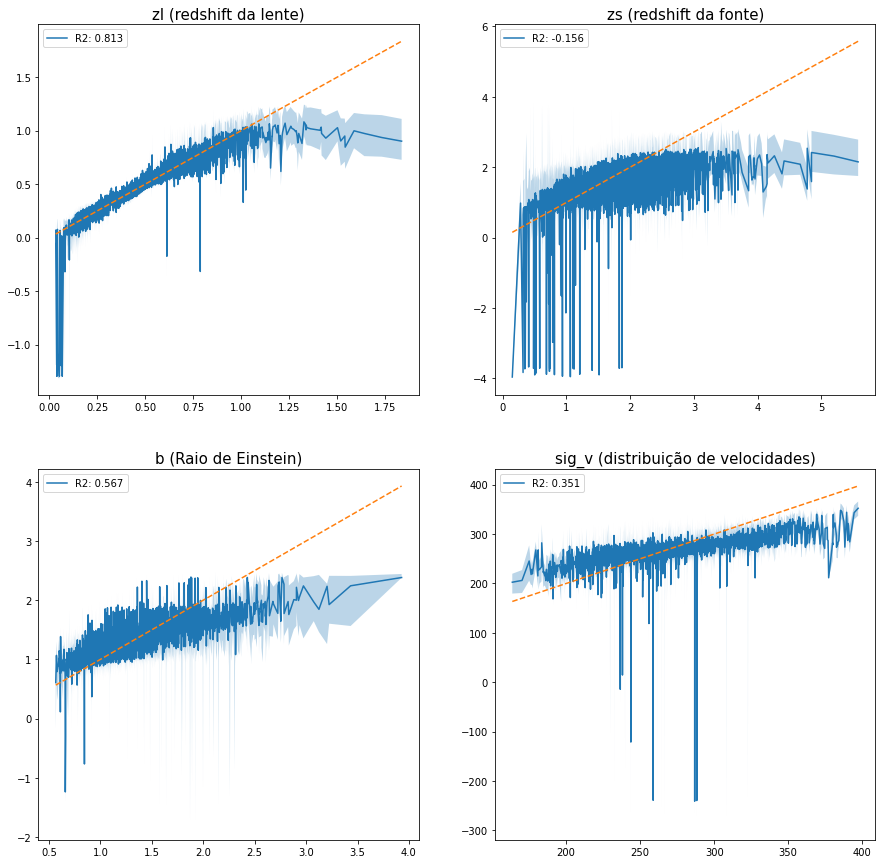

In [36]:
figure = plt.figure(figsize=(15,15))
axs = figure.subplots(2, 2)

y_test_0_sorted, zl_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_median)))
_, zl_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_sup)))
_, zl_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_inf)))

axs[0,0].plot(y_test_0_sorted, zl_median_sorted, label=f'R2: {round(r2[0],3)}')

axs[0,0].fill_between(x=y_test_0_sorted, y1=zl_sup_sorted, y2=zl_inf_sorted, alpha=0.3)

axs[0,0].plot(np.linspace(y_test_0_sorted[0], y_test_0_sorted[-1], 100), 
         np.linspace(y_test_0_sorted[0], y_test_0_sorted[-1], 100),
        linestyle='--')

axs[0,0].set_title('zl (redshift da lente)', fontsize=15)
axs[0,0].legend()

y_test_1_sorted, zs_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_median)))
_, zs_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_sup)))
_, zs_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_inf)))

axs[0,1].plot(y_test_1_sorted, zs_median_sorted, label=f'R2: {round(r2[1],3)}')

axs[0,1].fill_between(x=y_test_1_sorted, y1=zs_sup_sorted, y2=zs_inf_sorted, alpha=0.3)

axs[0,1].plot(np.linspace(y_test_1_sorted[0], y_test_1_sorted[-1], 100), 
         np.linspace(y_test_1_sorted[0], y_test_1_sorted[-1], 100),
        linestyle='--')

axs[0,1].set_title('zs (redshift da fonte)', fontsize=15)
axs[0,1].legend()

y_test_2_sorted, b_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_median)))
_, b_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_sup)))
_, b_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_inf)))

axs[1,0].plot(y_test_2_sorted, b_median_sorted, label=f'R2: {round(r2[2],3)}')

axs[1,0].fill_between(x=y_test_2_sorted, y1=b_sup_sorted, y2=b_inf_sorted, alpha=0.3)

axs[1,0].plot(np.linspace(y_test_2_sorted[0], y_test_2_sorted[-1], 100), 
         np.linspace(y_test_2_sorted[0], y_test_2_sorted[-1], 100),
        linestyle='--')
axs[1,0].set_title('b (Raio de Einstein)', fontsize=15)
axs[1,0].legend()

y_test_3_sorted, sig_v_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_median)))
_, sig_v_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_sup)))
_, sig_v_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_inf)))

axs[1,1].plot(y_test_3_sorted, sig_v_median_sorted, label=f'R2: {round(r2[3],3)}')

axs[1,1].fill_between(x=y_test_3_sorted, y1=sig_v_sup_sorted, y2=sig_v_inf_sorted, alpha=0.3)

axs[1,1].plot(np.linspace(y_test_3_sorted[0], y_test_3_sorted[-1], 100), 
         np.linspace(y_test_3_sorted[0], y_test_3_sorted[-1], 100),
        linestyle='--')

axs[1,1].set_title('sig_v (distribuição de velocidades)', fontsize=15)
axs[1,1].legend()

plt.show()

# E se utilizássemos apenas 1 dos canais?

A ideia dessa seção é fazer o mesmo que fizemos anteriormente, mas dessa vez utilizando apenas os dados do canal i. Ao final, teremos uma nova imagem como a que está acima e poderemos ver a influência de se ter mais canais para cada parâmetro sendo estimado.

In [37]:
images = np.array(catalog_df['unichannel_flat_images'].to_numpy())

t = []
for i in images:
    t.append(np.array(i))
images = np.array(t)
images.shape

(18598, 5776)

Como nosso objetivo é comparar os resultados, vamos manter o mesmo random_state na função train_test_split. Dessa forma, os dados referentes aos mesmos objetos serão utilizados no treino e no teste.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(images, values, test_size=0.25, random_state=50)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, images, values):
        'Initialization'
        self.images = images
        self.values = values

  def __len__(self):
        'Denotes the total number of samples'
        return self.values.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        x = values[index,:]
        y = images[index,:]
        return x, y


training_set = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=args.batch_size,shuffle=True)

test_set = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=args.batch_size,shuffle=True)

In [39]:
x_std = train_loader.dataset.images.std((0,1))
y_std = train_loader.dataset.values.std((0))
print('x_std, y_std: ',x_std,y_std)

x_std, y_std:  375.0985193551008 [ 0.24809922  0.75670841  0.4285546  39.70018173]


In [40]:
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

num_layers = 10
mhidden_features = 1200 
base_dist = nflows.distributions.StandardNormal((4,))

transformsi = []
for _ in range(num_layers):
    transformsi.append(create_linear_transform(param_dim=4))
    transformsi.append(PiecewiseRationalQuadraticCouplingTransform(_, 4, mhidden_features, context_size=5776)) 
transformsi.append(create_linear_transform(param_dim=4))
transformflow = CompositeTransform(transformsi)

model = Flow(transformflow, base_dist)

In [41]:
args.y_size = 4 
args.x_size = train_loader.dataset.images[0].shape[0]
pytorch_total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params to optimize:', pytorch_total_params_grad)

Total params to optimize: 168048680


In [42]:
images = images.astype(np.double)
values = values.astype(np.double)
model = model.double()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss_avg = []
time0 = time.time()

model.train()
for epoch in tqdm(range(1, args.num_epochs + 1)):
    train_loss = []
    for batch_idx, (params, data) in enumerate(train_loader):
        data = data.to(device)
        params = params.to(device)
        optimizer.zero_grad()

        x = torch.tensor(data[:,:].cpu().numpy(), dtype=torch.float32)/x_std
        y = torch.tensor(params[:,:].cpu().numpy(), dtype=torch.float32)/y_std

        optimizer.zero_grad()
        loss = -model.log_prob(inputs=y.double(), context=x.double()).mean()

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss_avg.append(np.mean(np.array(train_loss)))
    if epoch % args.log_interval ==0: print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item()))

print('Training: {0:2.2f} min'.format( (time.time()-time0)/60.) )

 25%|██▌       | 2/8 [22:42<1:08:10, 681.71s/it]

====> Epoch: 2 Average loss: 6.3206


 50%|█████     | 4/8 [45:17<45:14, 678.68s/it]  

====> Epoch: 4 Average loss: 4.2987


 75%|███████▌  | 6/8 [1:07:51<22:35, 677.90s/it]

====> Epoch: 6 Average loss: 2.9396


100%|██████████| 8/8 [1:30:27<00:00, 678.47s/it]

====> Epoch: 8 Average loss: 1.9824
Training: 90.46 min


Text(0, 0.5, '-log prob')

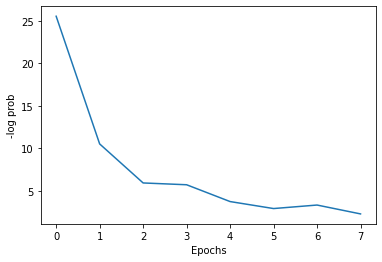

In [44]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('-log prob')

In [45]:
test_medians = []
test_sup = []
test_inf = []

slice = len(y_test)

for test_index in tqdm(range(slice)):
    nsamples = 2000


    samples_histo = model.sample(1,context=torch.tensor(x_test[test_index]).repeat(nsamples,1)/x_std).data.cpu().numpy()

    samples_histo = samples_histo[:,0,:]*y_std
    
    test_medians.append([np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.5)])
    
    test_sup.append([np.quantile(samples_histo[:,0], 0.84) - np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.84) - np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.84) - np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.84) - np.quantile(samples_histo[:,3], 0.5)])
    
    test_inf.append([np.quantile(samples_histo[:,0], 0.16) - np.quantile(samples_histo[:,0], 0.5),
                       np.quantile(samples_histo[:,1], 0.16) - np.quantile(samples_histo[:,1], 0.5),
                       np.quantile(samples_histo[:,2], 0.16) - np.quantile(samples_histo[:,2], 0.5),
                       np.quantile(samples_histo[:,3], 0.16) - np.quantile(samples_histo[:,3], 0.5)])

100%|██████████| 4650/4650 [7:22:50<00:00,  5.71s/it]  


In [46]:
r2 = r2_score(y_true = y_test[:len(test_medians)], y_pred = test_medians, multioutput='raw_values')

for i, j in zip(columns, r2):
    print(f'R2 score de{i}: {r2}')

R2 score dezl: [ 0.70002928  0.19593022  0.08642801 -0.06107599]
R2 score dezs: [ 0.70002928  0.19593022  0.08642801 -0.06107599]
R2 score deb: [ 0.70002928  0.19593022  0.08642801 -0.06107599]
R2 score desig_v: [ 0.70002928  0.19593022  0.08642801 -0.06107599]


In [47]:
zl_median = []
zl_sup = []
zl_inf = []

zs_median = []
zs_sup = []
zs_inf = []

b_median = []
b_sup = []
b_inf = []


sig_v_median = []
sig_v_sup = []
sig_v_inf = []

for i in range(len(test_medians)):
    zl_median.append(test_medians[i][0])
    zs_median.append(test_medians[i][1])
    b_median.append(test_medians[i][2])
    sig_v_median.append(test_medians[i][3])
    
    zl_sup.append(test_sup[i][0] + test_medians[i][0])
    zs_sup.append(test_sup[i][1] + test_medians[i][1])
    b_sup.append(test_sup[i][2] + test_medians[i][2])
    sig_v_sup.append(test_sup[i][3] + test_medians[i][3])
    
    zl_inf.append(test_inf[i][0] + test_medians[i][0])
    zs_inf.append(test_inf[i][1] + test_medians[i][1])
    b_inf.append(test_inf[i][2] + test_medians[i][2])
    sig_v_inf.append(test_inf[i][3] + test_medians[i][3])

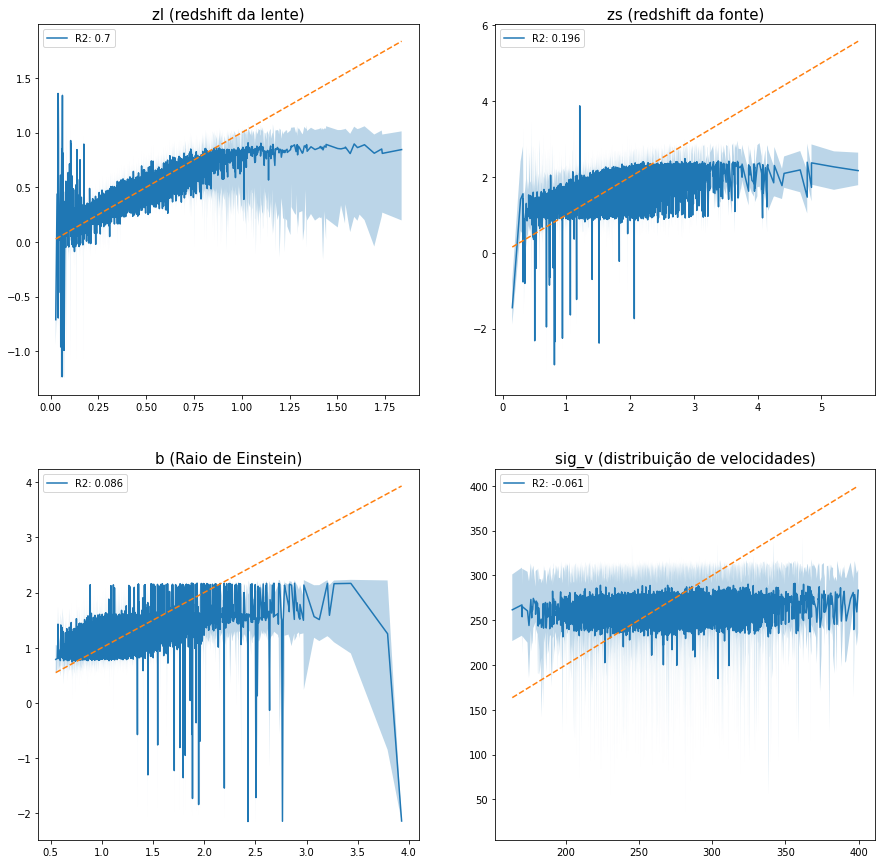

In [50]:
figure = plt.figure(figsize=(15,15))
axs = figure.subplots(2, 2)

y_test_0_sorted, zl_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_median)))
_, zl_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_sup)))
_, zl_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),0], zl_inf)))

axs[0,0].plot(y_test_0_sorted, zl_median_sorted, label=f'R2: {round(r2[0],3)}')

axs[0,0].fill_between(x=y_test_0_sorted, y1=zl_sup_sorted, y2=zl_inf_sorted, alpha=0.3)

axs[0,0].plot(np.linspace(y_test_0_sorted[0], y_test_0_sorted[-1], 100), 
         np.linspace(y_test_0_sorted[0], y_test_0_sorted[-1], 100),
        linestyle='--')

axs[0,0].set_title('zl (redshift da lente)', fontsize=15)
axs[0,0].legend()

y_test_1_sorted, zs_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_median)))
_, zs_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_sup)))
_, zs_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),1], zs_inf)))

axs[0,1].plot(y_test_1_sorted, zs_median_sorted, label=f'R2: {round(r2[1],3)}')

axs[0,1].fill_between(x=y_test_1_sorted, y1=zs_sup_sorted, y2=zs_inf_sorted, alpha=0.3)

axs[0,1].plot(np.linspace(y_test_1_sorted[0], y_test_1_sorted[-1], 100), 
         np.linspace(y_test_1_sorted[0], y_test_1_sorted[-1], 100),
        linestyle='--')

axs[0,1].set_title('zs (redshift da fonte)', fontsize=15)
axs[0,1].legend()

y_test_2_sorted, b_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_median)))
_, b_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_sup)))
_, b_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),2], b_inf)))

axs[1,0].plot(y_test_2_sorted, b_median_sorted, label=f'R2: {round(r2[2],3)}')

axs[1,0].fill_between(x=y_test_2_sorted, y1=b_sup_sorted, y2=b_inf_sorted, alpha=0.3)

axs[1,0].plot(np.linspace(y_test_2_sorted[0], y_test_2_sorted[-1], 100), 
         np.linspace(y_test_2_sorted[0], y_test_2_sorted[-1], 100),
        linestyle='--')
axs[1,0].set_title('b (Raio de Einstein)', fontsize=15)
axs[1,0].legend()

y_test_3_sorted, sig_v_median_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_median)))
_, sig_v_sup_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_sup)))
_, sig_v_inf_sorted = zip(*sorted(zip(y_test[:len(test_medians),3], sig_v_inf)))

axs[1,1].plot(y_test_3_sorted, sig_v_median_sorted, label=f'R2: {round(r2[3],3)}')

axs[1,1].fill_between(x=y_test_3_sorted, y1=sig_v_sup_sorted, y2=sig_v_inf_sorted, alpha=0.3)

axs[1,1].plot(np.linspace(y_test_3_sorted[0], y_test_3_sorted[-1], 100), 
         np.linspace(y_test_3_sorted[0], y_test_3_sorted[-1], 100),
        linestyle='--')

axs[1,1].set_title('sig_v (distribuição de velocidades)', fontsize=15)
axs[1,1].legend()

plt.show()